# Background



In [1]:
import bayesld
import tempfile, subprocess
import pandas as pd


def process(ts, recombination_rate):
    # Use a temporary directory for intermediate files
    with tempfile.TemporaryDirectory() as tmpdir:
        trees_path = f"{tmpdir}/example.trees"
        bcf_path = f"{tmpdir}/example.bcf"

        # Dump tree sequence
        ts.dump(trees_path)

        # Run tskit -> bcftools pipeline
        subprocess.run(
            f"tskit vcf --allow-position-zero {trees_path} | bcftools view -O b > {bcf_path}",
            shell=True,
            check=True,
        )

        # Index BCF
        subprocess.run(["bcftools", "index", bcf_path], check=True)

        # Compute LD
        mean, variance, n, left, right = bayesld.compute_ld(
            bcf_path, "1", recombination_rate
        )

    return pd.DataFrame(
        {
            "mean": mean,
            "variance": variance,
            "n": n,
            "left": left / 100,
            "right": right / 100,
        }
    )


def simulate_data():
    import msprime

    theta = [2000]
    n_samples = 20
    RECOMBINATION_RATE = MUTATION_RATE = 1e-8
    CONTIG_LENGTH = 1e8
    seed = 1234
    demography = msprime.Demography()
    demography.add_population(name="p0", initial_size=theta[0])
    replicates = msprime.sim_ancestry(
        samples={"p0": n_samples},
        recombination_rate=RECOMBINATION_RATE,
        sequence_length=CONTIG_LENGTH,
        random_seed=seed,
        demography=demography,
        num_replicates=10,
    )
    for i, ts in enumerate(replicates):
        mts = msprime.sim_mutations(ts, rate=MUTATION_RATE, random_seed=seed + i)
        res = process(mts, RECOMBINATION_RATE).assign(seed=i)
        yield res

In [2]:
df = pd.concat(x for x in simulate_data())
data = df.pivot(index="seed", columns="left", values="mean").to_numpy()

In [3]:
n_samples = 20

In [4]:
import pymc as pm
import arviz as az
import numpy as np
import pytensor.tensor as pt
import bayesld.models

# Standardize data
empirical_sigma = data.std(ddof=1, axis=0)
left, right = df.left.unique(), df.right.unique()
n_contigs, n_bins = data.shape

coords = {"contig": np.arange(n_contigs), "bins": np.arange(n_bins)}

with pm.Model(coords=coords) as model:
    # Effective population size
    Ne = pm.Uniform("Ne", 0, 5000)

    # Diagonal covariance: independent std for each bin
    sigma = pm.Exponential("sigma", lam=1 / empirical_sigma, dims="bins")

    # Expected LD (standardized)
    LD = pm.Deterministic(
        "LD",
        bayesld.models.expected_ld_constant(Ne, left, right, sample_size=n_samples),
        dims="bins",
    )

    # Observed data: MvNormal with diagonal covariance
    obs = pm.MvNormal(
        "obs",
        mu=LD,
        cov=pt.diag(sigma**2),  # diagonal covariance
        observed=data,
        dims=("contig", "bins"),
    )

    trace = pm.sample()

az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ne,2155.070,56.057,2050.361,2258.562,0.692,0.933,6853.0,3256.0,1.0
sigma[0],0.002,0.001,0.001,0.003,0.000,0.000,7295.0,3236.0,1.0
sigma[1],0.002,0.001,0.001,0.003,0.000,0.000,8506.0,3047.0,1.0
sigma[2],0.003,0.001,0.002,0.004,0.000,0.000,8242.0,2917.0,1.0
sigma[3],0.002,0.001,0.001,0.003,0.000,0.000,7771.0,2937.0,1.0
sigma[4],0.001,0.000,0.001,0.002,0.000,0.000,9479.0,3190.0,1.0
sigma[5],0.001,0.000,0.001,0.002,0.000,0.000,8167.0,3014.0,1.0
sigma[6],0.002,0.000,0.001,0.002,0.000,0.000,7232.0,3035.0,1.0
sigma[7],0.001,0.000,0.001,0.002,0.000,0.000,8849.0,2589.0,1.0
sigma[8],0.001,0.000,0.001,0.002,0.000,0.000,6851.0,2446.0,1.0


array([[<Axes: title={'center': 'Ne'}>, <Axes: title={'center': 'Ne'}>]],
      dtype=object)

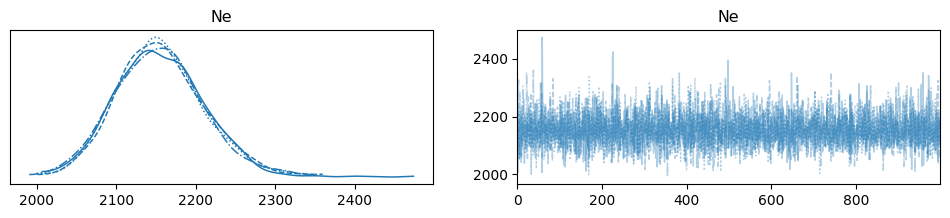

In [5]:
az.plot_trace(trace, var_names="Ne")

In [6]:
with model:
    pm.compute_log_likelihood(trace)
loo = az.loo(trace)
loo

Output()

/Users/currocam/Documents/Dev/bayesld/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   952.53    11.19
p_loo       19.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        5   50.0%
   (0.70, 1]   (bad)         5   50.0%
   (1, Inf)   (very bad)    0    0.0%

In [7]:
with model.copy():
    LD_pp = pm.sample_posterior_predictive(trace)

Sampling: [obs]


Output()

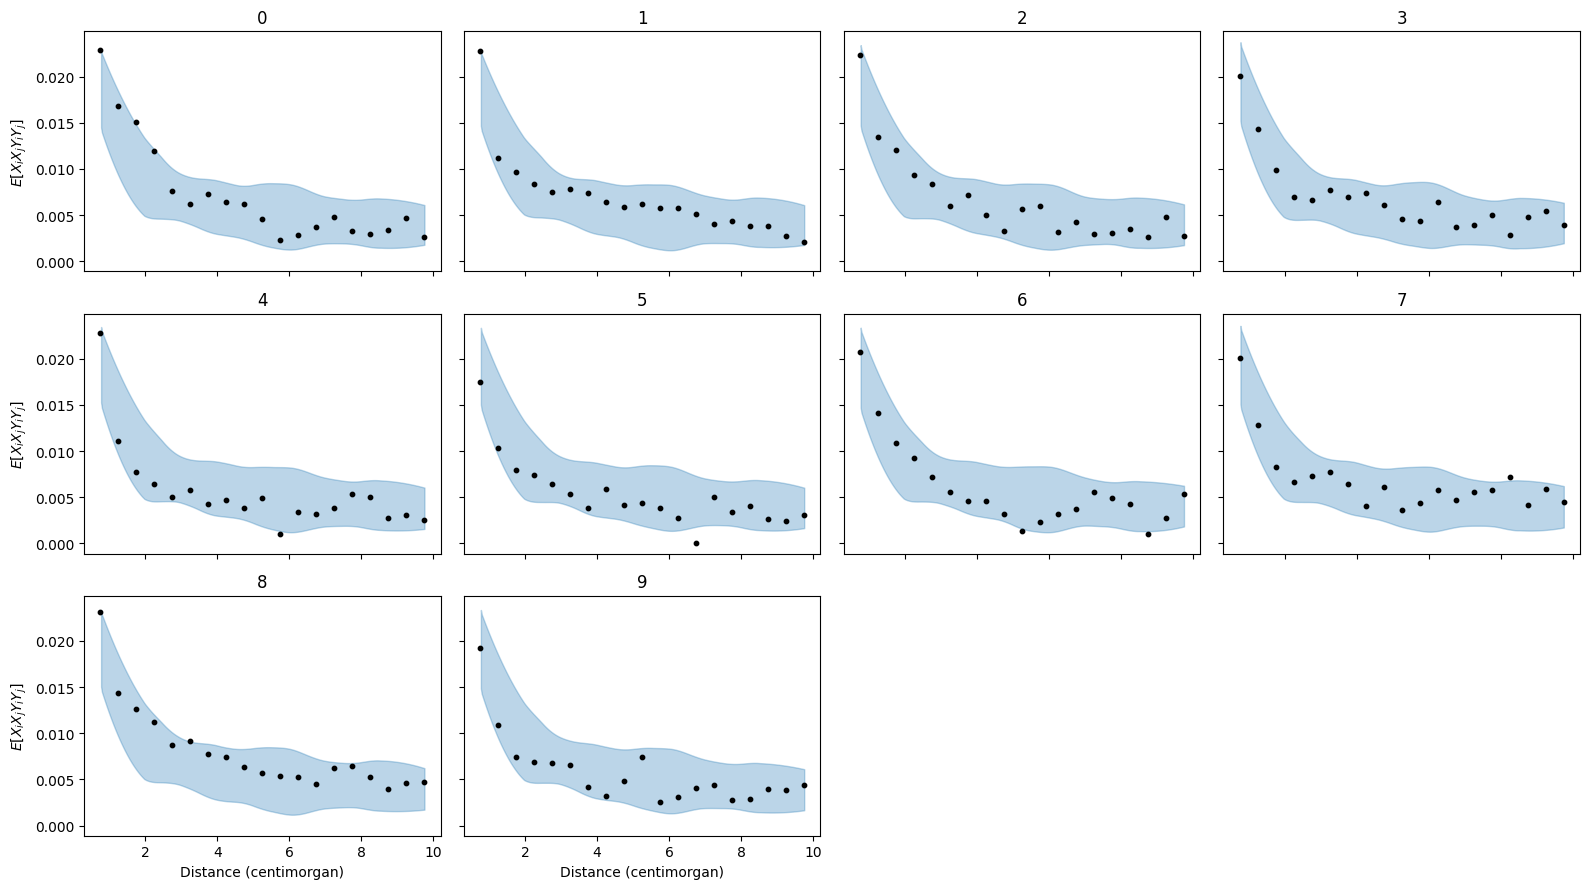

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

contigs = coords["contig"]
n_contigs = len(contigs)

# Layout: roughly square
ncols = int(np.ceil(np.sqrt(n_contigs)))
nrows = int(np.ceil(n_contigs / ncols))

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True
)
axes = axes.flatten()

x = (left + right) / 2 * 100

# HDI across chains/draws for each contig/bin
hdi_all = az.hdi(LD_pp.posterior_predictive["obs"], input_core_dims=[["chain", "draw"]])

for i, contig in enumerate(contigs):
    ax = axes[i]

    # Select contig + variable → DataArray → numpy
    hdi_c = hdi_all["obs"].sel(contig=contig).to_numpy()

    az.plot_hdi(
        x,
        hdi_data=hdi_c,
        ax=ax,
        color="C0",
        fill_kwargs={"alpha": 0.3},
    )

    # Observed data
    y_obs = LD_pp.observed_data["obs"].sel(contig=contig).to_numpy()
    ax.scatter(x, y_obs, s=10, color="black")

    ax.set_title(str(contig))
    if i % ncols == 0:
        ax.set_ylabel(r"$E[X_i X_j Y_i Y_j]$")
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel("Distance (centimorgan)")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()